[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-3/dynamic-breakpoints.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239526-lesson-4-dynamic-breakpoints)

# Dynamic breakpoints 

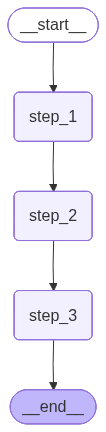

In [38]:
from IPython.display import Image, display

from typing_extensions import TypedDict
from langgraph.checkpoint.memory import MemorySaver
from langgraph.errors import NodeInterrupt
from langgraph.graph import START, END, StateGraph

class State(TypedDict):
    input: str

def step_1(state: State) -> State:
    print("---Step 1---")
    return state

def step_2(state: State) -> State:
    # Let's optionally raise a NodeInterrupt if the length of the input is longer than 5 characters
    if len(state['input']) > 5:
        raise NodeInterrupt(f"Received input that is longer than 5 characters: {state['input']}")
    
    print("---Step 2---")
    return state

def step_3(state: State) -> State:
    print("---Step 3---")

    if state['input'].lower() == "stop":
        raise NodeInterrupt(f"Received instructions to stop execution immediately.")
    return state

builder = StateGraph(State)
builder.add_node("step_1", step_1)
builder.add_node("step_2", step_2)
builder.add_node("step_3", step_3)
builder.add_edge(START, "step_1")
builder.add_edge("step_1", "step_2")
builder.add_edge("step_2", "step_3")
builder.add_edge("step_3", END)

memory = MemorySaver()

graph = builder.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))

In [39]:
initial_input = {"input": "STOP"}
thread_config = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread_config, stream_mode="values"):
    print(event)

{'input': 'STOP'}
---Step 1---
{'input': 'STOP'}
---Step 2---
{'input': 'STOP'}
---Step 3---
{'__interrupt__': (Interrupt(value='Received instructions to stop execution immediately.', id='placeholder-id'),)}


C:\Users\Akash\AppData\Local\Temp\ipykernel_2268\1828575392.py:27: LangGraphDeprecatedSinceV10: NodeInterrupt is deprecated. Please use `langgraph.types.interrupt` instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  raise NodeInterrupt(f"Received instructions to stop execution immediately.")


In [40]:
initial_input = {"input": "MoreThan5LettersLong"}
thread_config = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread_config, stream_mode="values"):
    print(event)

{'input': 'MoreThan5LettersLong'}
---Step 1---
{'input': 'MoreThan5LettersLong'}
{'__interrupt__': (Interrupt(value='Received input that is longer than 5 characters: MoreThan5LettersLong', id='placeholder-id'),)}


C:\Users\Akash\AppData\Local\Temp\ipykernel_2268\1828575392.py:18: LangGraphDeprecatedSinceV10: NodeInterrupt is deprecated. Please use `langgraph.types.interrupt` instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  raise NodeInterrupt(f"Received input that is longer than 5 characters: {state['input']}")


In [41]:
state = graph.get_state(thread_config)
print(state.next)

('step_2',)


We can see that the `Interrupt` is logged to state.

In [42]:
print(state.tasks)

(PregelTask(id='c7404224-fa73-f7b0-ef83-fe303d1af2ee', name='step_2', path=('__pregel_pull', 'step_2'), error=None, interrupts=(Interrupt(value='Received input that is longer than 5 characters: MoreThan5LettersLong', id='placeholder-id'),), state=None, result=None),)


We can try to resume the graph from the breakpoint. 

But, this just re-runs the same node! 

Unless state is changed we will be stuck here.

In [43]:
for event in graph.stream(None, thread_config, stream_mode="values"):
    print(event)

{'input': 'MoreThan5LettersLong'}
{'__interrupt__': (Interrupt(value='Received input that is longer than 5 characters: MoreThan5LettersLong', id='placeholder-id'),)}


C:\Users\Akash\AppData\Local\Temp\ipykernel_2268\1828575392.py:18: LangGraphDeprecatedSinceV10: NodeInterrupt is deprecated. Please use `langgraph.types.interrupt` instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  raise NodeInterrupt(f"Received input that is longer than 5 characters: {state['input']}")


In [44]:
state = graph.get_state(thread_config)
print(state.next)

('step_2',)


Now, we can update state.

In [45]:
input_trunc= state.values['input'][:5]
graph.update_state(
    thread_config,
    {"input": input_trunc},
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b348b-ca0c-679b-8006-3eef06ba4d2f'}}

In [46]:
for event in graph.stream(None, thread_config, stream_mode="values"):
    print(event)

{'input': 'MoreT'}
---Step 2---
{'input': 'MoreT'}
---Step 3---
{'input': 'MoreT'}


We connect to it via the SDK.

In [47]:
from langgraph_sdk import get_client

# This is the URL of the local development server
URL = "http://127.0.0.1:2024"
client = get_client(url=URL)

# Search all hosted graphs
assistants = await client.assistants.search()

In [48]:
thread = await client.threads.create()
input_dict = {"input": "hello world"}

async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="dynamic_breakpoints",
    input=input_dict,
    stream_mode="values",):
    
    print(f"Receiving new event of type: {chunk.event}...")
    print(chunk.data)
    print("\n\n")

Receiving new event of type: metadata...
{'run_id': '019a2643-6a06-7066-8127-f5f122983e4f', 'attempt': 1}



Receiving new event of type: values...
{'input': 'hello world'}



Receiving new event of type: values...
{'input': 'hello world'}



Receiving new event of type: values...
{'__interrupt__': [{'value': 'Received input that is longer than 5 characters: hello world', 'id': 'placeholder-id'}]}





In [49]:
current_state = await client.threads.get_state(thread['thread_id'])

In [50]:
current_state['next']

['step_2']

In [51]:
await client.threads.update_state(thread['thread_id'], {"input": "hi!"})

{'checkpoint': {'thread_id': '896e4f11-00b1-4948-927e-985f7f9d02a1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b348b-d6e1-6e05-8002-af718cf264cd'},
 'configurable': {'thread_id': '896e4f11-00b1-4948-927e-985f7f9d02a1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b348b-d6e1-6e05-8002-af718cf264cd'},
 'checkpoint_id': '1f0b348b-d6e1-6e05-8002-af718cf264cd'}

In [52]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="dynamic_breakpoints",
    input=None,
    stream_mode="values",):
    
    print(f"Receiving new event of type: {chunk.event}...")
    print(chunk.data)
    print("\n\n")

Receiving new event of type: metadata...
{'run_id': '019a2643-6dd3-74bc-af3d-9dd64bb76683', 'attempt': 1}



Receiving new event of type: values...
{'input': 'hi!'}



Receiving new event of type: values...
{'input': 'hi!'}



Receiving new event of type: values...
{'input': 'hi!'}





In [53]:
current_state = await client.threads.get_state(thread['thread_id'])
current_state

{'values': {'input': 'hi!'},
 'next': [],
 'tasks': [],
 'metadata': {'langgraph_auth_user': None,
  'langgraph_auth_user_id': '',
  'langgraph_auth_permissions': [],
  'langgraph_request_id': 'ec776e74-4aba-43d7-8779-9d709a21d4bd',
  'graph_id': 'dynamic_breakpoints',
  'assistant_id': '6f6fce9a-b777-529d-9699-dd340ddec86c',
  'user_id': '',
  'created_by': 'system',
  'run_attempt': 1,
  'langgraph_version': '1.0.1',
  'langgraph_api_version': '0.4.42',
  'langgraph_plan': 'developer',
  'langgraph_host': 'self-hosted',
  'langgraph_api_url': 'http://127.0.0.1:2024',
  'run_id': '019a2643-6dd3-74bc-af3d-9dd64bb76683',
  'thread_id': '896e4f11-00b1-4948-927e-985f7f9d02a1',
  'source': 'loop',
  'step': 4,
  'parents': {}},
 'created_at': '2025-10-27T15:22:25.495774+00:00',
 'checkpoint': {'checkpoint_id': '1f0b348b-dfcb-653f-8004-f2a62ff62554',
  'thread_id': '896e4f11-00b1-4948-927e-985f7f9d02a1',
  'checkpoint_ns': ''},
 'parent_checkpoint': {'checkpoint_id': '1f0b348b-dfbd-6cf4-800

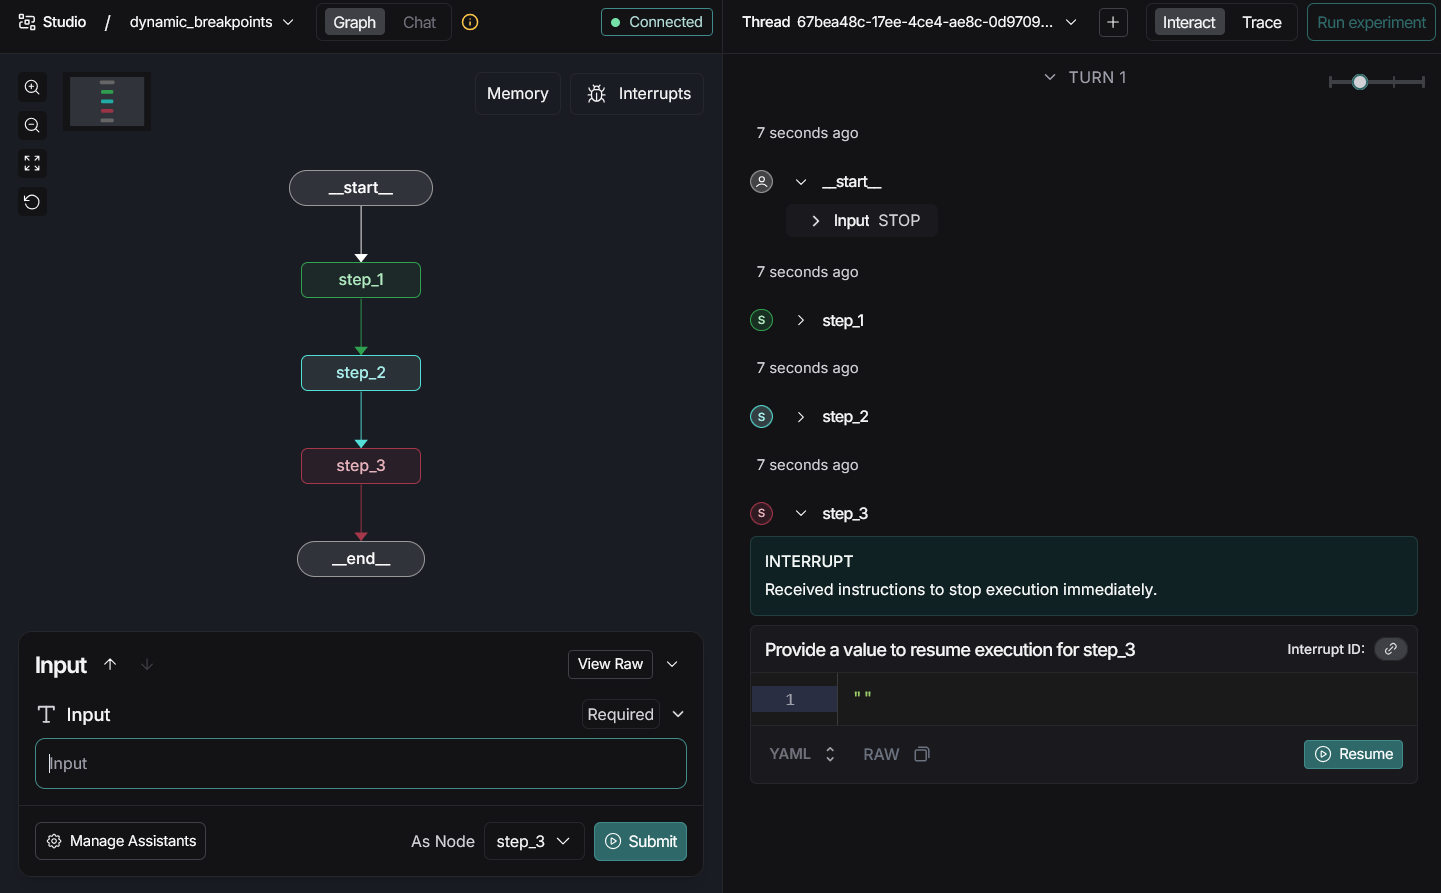